## Machine Learning Techniques for Distinguishing Between Human and AI-Generated Text
**(Part 2 - Best Model Interpretation)**

** by Mykhaylo Chuba **


####


#### Import Libraries

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import nltk
import string
import re
import shap
import warnings
warnings.simplefilter(action='ignore')
from wordcloud import WordCloud, STOPWORDS
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, mean_squared_error, accuracy_score, recall_score,f1_score

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelchuba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/michaelchuba/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/michaelchuba/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/michaelchuba/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelchuba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaelchuba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


####


#### Data Upload and Setup

In [3]:
# Load data set
data = pd.read_csv('AI_Human.csv')

In [4]:
# Convert int64 data type to int
data['generated'] = data['generated'].astype(int)

In [5]:
# Reduce the size of the dataset to 20,000 rows and establish the class balance as 50/50   

# Filter the DataFrame by class
ai_generated = data[data['generated'] == 1]
not_ai_generated = data[data['generated'] == 0]

# Sample 25000 rows from each class
ai_sample = ai_generated.sample(n=10000, random_state=123) 
not_ai_sample = not_ai_generated.sample(n=10000, random_state=123)

# Combine and shuffle the samples
data1 = pd.concat([ai_sample, not_ai_sample]).sample(frac=1, random_state=123)

In [6]:
# Rename columns
data1.columns = ['text', 'ai_generated']

# Reset the index
data1.reset_index(drop=True, inplace=True)

In [7]:
data1.head()

,text,ai_generated
0,"Dear Principle,\n\nI think that the principle ...",0
1,"Dear TEACHER_NAME,\n\nIn consideration of the ...",0
2,When people ask for advice they sometimes talk...,0
3,I agree that advertisements often make product...,1
4,Education is a life-long process. I agree with...,1


In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          20000 non-null  object
 1   ai_generated  20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


####


#### Data Processing

In [8]:
# Split data into train and test
X = data1['text']
y = data1['ai_generated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [9]:
# Set up a function for tokenization, removing stop words, punctuation, numbers; set lower case, and lemmatize
def preprocess_text(text):
    tokenizer = TweetTokenizer(preserve_case = False)
    swords = stopwords.words('english')
    punc = list(string.punctuation)
    lemmatizer = WordNetLemmatizer()
    
    processed_text = []
    for entry in text:
        entry = re.sub(r'\d+', '', entry)
        tokens = tokenizer.tokenize(entry)
        processed_text.append([lemmatizer.lemmatize(word) for word in tokens if word not in swords and word not in punc])
    return processed_text

In [10]:
# Process the text using the above function
processing_X_train = preprocess_text(X_train)
X_train_processed = [' '.join(x) for x in processing_X_train]

processing_X_test = preprocess_text(X_test)
X_test_processed = [' '.join(x) for x in processing_X_test]

In [20]:
# Add professed text to the dataframe
data1['processed_text'] = preprocess_text(X)
data1.head()

,text,ai_generated,processed_text
0,"Dear Principle,\n\nI think that the principle ...",0,"[dear, principle, think, principle, unfair, st..."
1,"Dear TEACHER_NAME,\n\nIn consideration of the ...",0,"[dear, teacher_name, consideration, school, gr..."
2,When people ask for advice they sometimes talk...,0,"[people, ask, advice, sometimes, talk, one, pe..."
3,I agree that advertisements often make product...,1,"[agree, advertisement, often, make, product, s..."
4,Education is a life-long process. I agree with...,1,"[education, life-long, process, agree, stateme..."


####


#### Logistic Regression Model

In [11]:
# Setup Logistic Regression pipeline

lgr_pipe = Pipeline([('vect', CountVectorizer()),
                       ('lgr', LogisticRegression(max_iter=1000))])

lgr_params = { 'vect__max_features': [1000, 2000, 5000],
          'lgr__C': [0.01, 0.1, 1, 10, 100]
    }


# Configure GridSearchCV
lgr_grid = GridSearchCV(lgr_pipe, param_grid=lgr_params)
lgr_grid.fit(X_train_processed, y_train)

# Output the best parameters, time and scores
lgr_best_params = lgr_grid.best_params_
lgr_acc = lgr_grid.score(X_test_processed, y_test)
lgr_recall = recall_score(y_test, lgr_grid.predict(X_test_processed))
lgr_precision = precision_score(y_test, lgr_grid.predict(X_test_processed))
lgr_f1 = f1_score(y_test, lgr_grid.predict(X_test_processed))

lgr_index = lgr_grid.best_index_
lgr_time = lgr_grid.cv_results_['mean_fit_time'][lgr_index]


# Output the best parameters and score
print("Best parameters:", lgr_best_params)
print("Accuracy:", lgr_acc)
print("Precision Score:", lgr_precision)
print("Recall Score:", lgr_recall)
print("F1 Score:", lgr_f1)
print("Time to fit:", lgr_time)

Best parameters: {'lgr__C': 0.1, 'vect__max_features': 5000}
Accuracy: 0.9826666666666667
Precision Score: 0.9790628115653041
Recall Score: 0.9862738533645798
F1 Score: 0.9826551034022681
Time to fit: 1.547755765914917


####


#### Data Analysis and Visualization

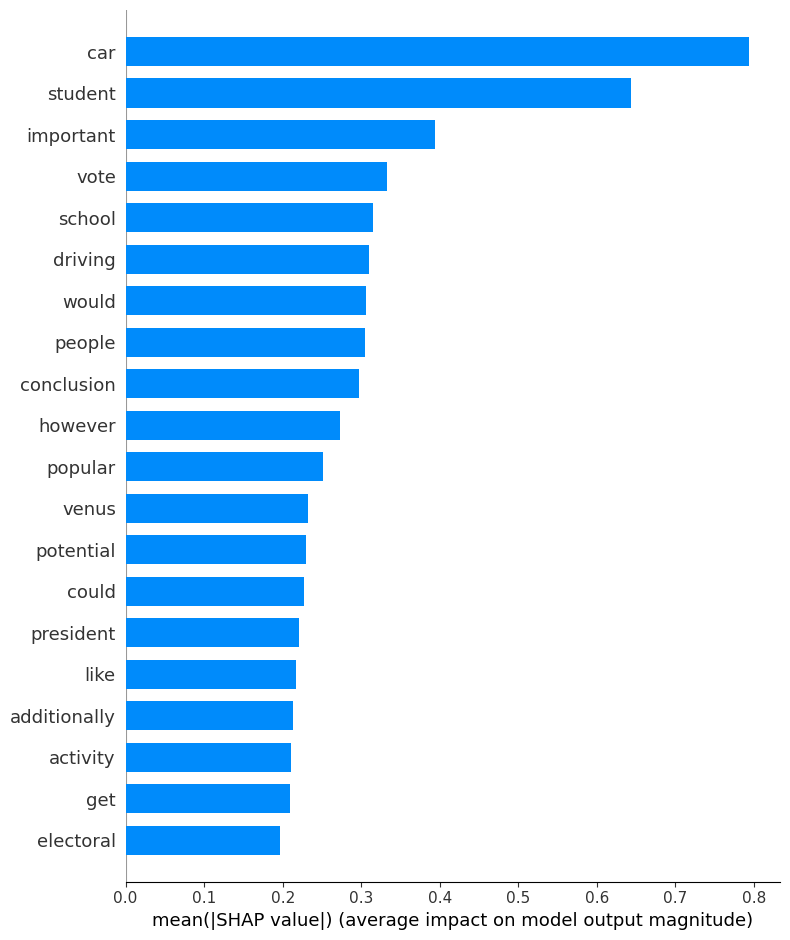

In [37]:
# Show model's most important features

best_lgr_model = lgr_grid.best_estimator_
vectorizer = best_lgr_model.named_steps['vect']
X_train_transformed = vectorizer.transform(X_train_processed)
explainer = shap.LinearExplainer(best_lgr_model.named_steps['lgr'], X_train_transformed, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=vectorizer.get_feature_names_out(), plot_type="bar", class_names=['Class 0', 'Class 1'])

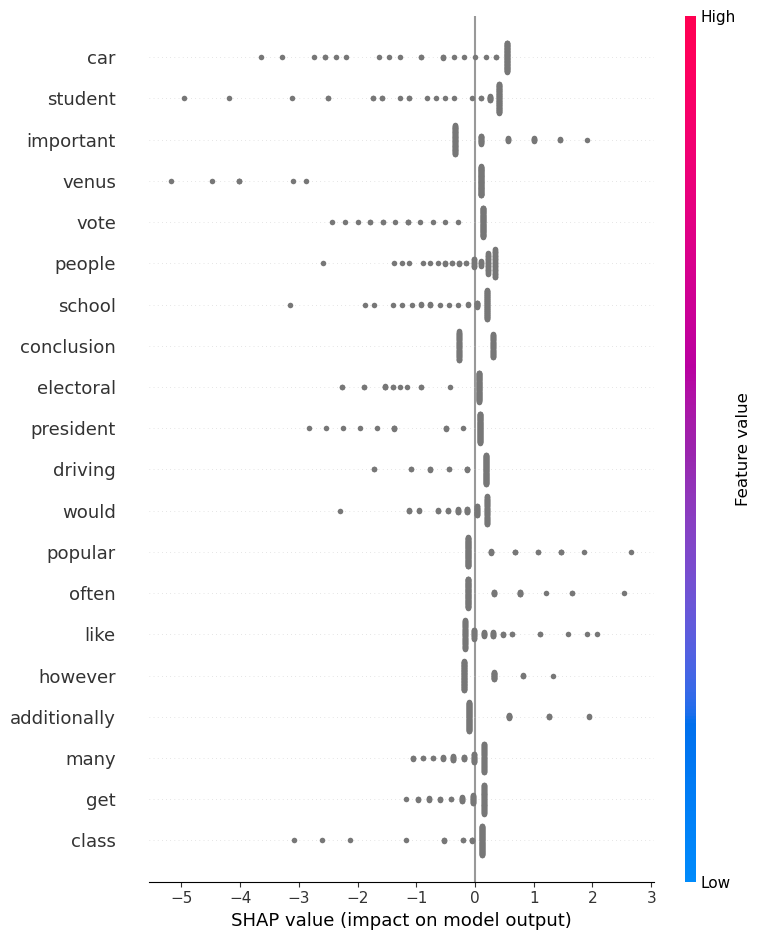

In [38]:
# Generate values for a subset of the training set for better visualization
subset = vectorizer.transform(X_train_processed[:100])  # Adjust the subset size based on your dataset
shap_values_subset = explainer.shap_values(subset)

# Visualizing the summary plot
shap.summary_plot(shap_values_subset, subset, feature_names=vectorizer.get_feature_names_out())

In [39]:
# Create and flatten the list of lists for ai and non-ai words

ai_word_list = data1.query('ai_generated == 1')['processed_text'].tolist()
non_ai_word_list = data1.query('ai_generated == 0')['processed_text'].tolist()

ai_words = [word for sublist in ai_word_list for word in sublist]
non_ai_words = [word for sublist in non_ai_word_list for word in sublist]
all_words = ai_words + non_ai_words

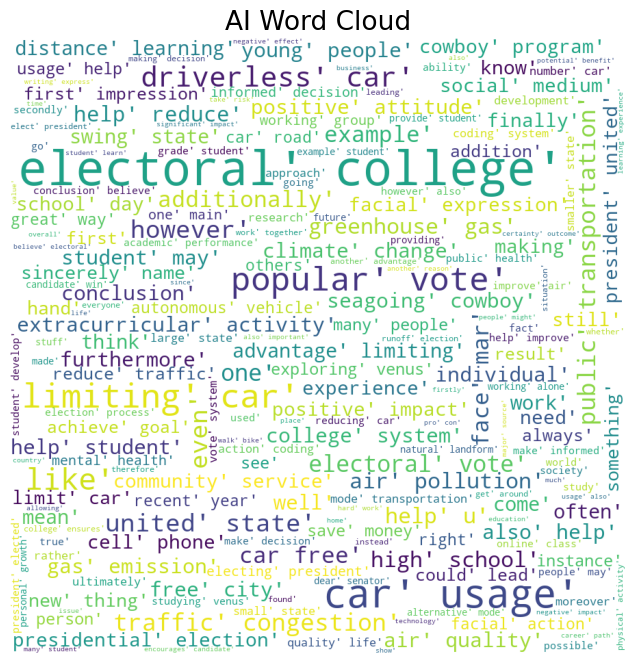

In [28]:
# Show AI word cloud 
ai_wordcloud = WordCloud(width = 900, height = 900, stopwords = STOPWORDS, background_color = 'white').generate_from_text(str(ai_words))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(ai_wordcloud)
plt.axis('off')
plt.title("AI Word Cloud", fontsize = 19)
plt.show()

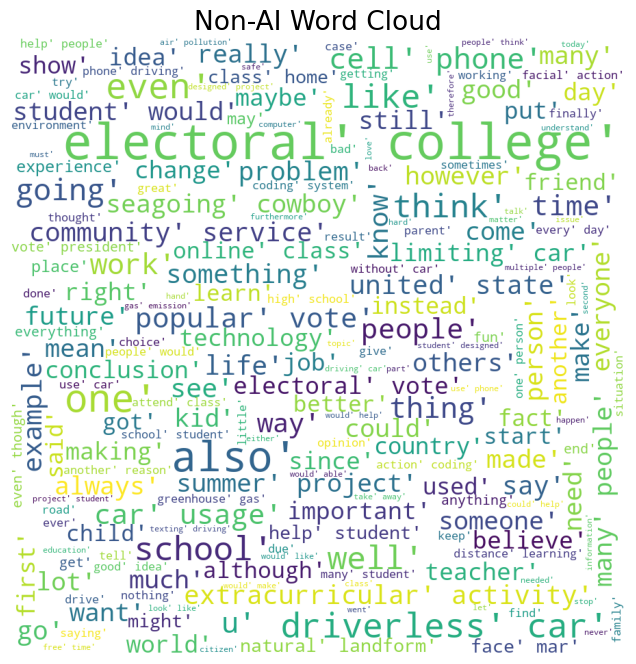

In [29]:
#Non-AI word cloud 
non_ai_wordcloud = WordCloud(width = 900, height = 900, stopwords = STOPWORDS, background_color = 'white').generate(str(non_ai_words))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(non_ai_wordcloud)
plt.axis('off')
plt.title("Non-AI Word Cloud", fontsize = 19)
plt.show()